## Inteligencia Artificial
## - Laboratorio 5 -
Autores:
- Mark Albrand 
- Jimena Hernández

### Task 1 - Graph-Search

In [4]:
import matplotlib.pylab as plt
import numpy as np

### Task 1.1 - Discretización de la imagen

In [5]:
from PIL import Image
import numpy as np
def convertir_a_discreto(imagen_path, tamano_bloque):
    # Cargar la imagen
    imagen = Image.open(imagen_path)
    imagen_np = np.array(imagen)
    
    # Dimensiones de la imagen
    alto, ancho, _ = imagen_np.shape
    
    nuevo_alto = (alto // tamano_bloque) + 1
    nuevo_ancho = (ancho // tamano_bloque) + 1

    print(f'Alto: {alto}, Ancho: {ancho}')
    print(f'Nuevo alto: {nuevo_alto}, Nuevo ancho: {nuevo_ancho}')

    # Redimensionar la imagen
    imagen_salida = np.zeros((nuevo_alto, nuevo_ancho, 3), dtype=np.uint8)
    
    for y in range(0, alto, tamano_bloque):
        for x in range(0, ancho, tamano_bloque):
            new_y = y // tamano_bloque
            new_x = x // tamano_bloque
            # Extraer el bloque
            bloque = imagen_np[y:y+tamano_bloque, x:x+tamano_bloque]
            
            # Calcular el color promedio del bloque
            color_promedio = bloque.mean(axis=(0,1)).astype(int)
            #convertir los colores difuminados al color mas predominante
            #verde
            if color_promedio[1] > color_promedio[0] and color_promedio[1] > color_promedio[2]:
                color_promedio[1] = 255
                color_promedio[0] = 0
                color_promedio[2] = 0 
            #rojo
            elif color_promedio[0] > color_promedio[1] and color_promedio[0] > color_promedio[2]:
                color_promedio[0] = 255
                color_promedio[1] = 0
                color_promedio[2] = 0

            #grises
            elif color_promedio[0] == color_promedio[1] and color_promedio[0] == color_promedio[2] and color_promedio[0]< 255:
                color_promedio[0] = 0
                color_promedio[1] = 0
                color_promedio[2] = 0

            else:
                color_promedio[0] = 255
                color_promedio[1] = 255
                color_promedio[2] = 255
            
            # Asignar el color promedio al bloque correspondiente en la imagen de salida
            imagen_salida[new_y, new_x] = color_promedio
    
    imagen_discreta = Image.fromarray(imagen_salida)
    return imagen_discreta

Alto: 582, Ancho: 582
Nuevo alto: 59, Nuevo ancho: 59


Las áreas blancas representan caminos libres
Las áreas negras representan paredes sobre las cuales no se puede pasar
Las áreas verdes representan la meta (goalTest positivos) (pueden ser varios)
La área roja representa el punto de inicio (solo podrá haber uno)

### Task 1.2 - Framework de Problemas

Puede entenderse como un framework con los siguientes
elementos
- ○ Estado inicial (s_start) CHEQUE
- ○ Función de acción actions(s) → {a 1, a 2,...,a n} CHEQUE
- ○ Función de costo de paso cost(s,a,s’) → R CHEQUE
-    Estado actual, acción y estado siguiente -> Cuánto cuesta hacer el moviemiento
- ○ Función de resultados results(s,a) → s’
-    Se usa después de actions, dice a que estado se llega usando lo que dio actions
- ○ Función de goalTest(s) → {True, False}
    Se pasa de cada config nueva (estado actual), si es la meta o no

● Además, algunas veces es útil agregar
- ○ Función de costo de ruta pathCost(s 1, s 2,...,s n) → R
■ s i = results(s i-1,a i )

In [9]:
from typing import TypedDict

class legend_dict(TypedDict):
    """
    Define el tipo de dato para el diccionario de leyenda
    Los numpy arrays son de 3 elementos, representando los colores RGB
    """
    wall: np.array
    path: np.array
    start: np.array
    end: np.array


class SolveMaze:
    maze: np.array
    starting_point: tuple[int, int]  # (y, x)

    legend: legend_dict = {
        "wall": np.array([0, 0, 0]),  # black
        "path": np.array([255, 255, 255]),  # white
        "start": np.array([255, 0, 0]),  # red
        "end": np.array([0, 255, 0])  # green
    }

    def __init__(self, maze: np.array):
        if maze.ndim != 3:
            raise ValueError("Maze debe ser un arreglo tridimensional")

        self.maze = maze
        self.starting_point = self._findStartinPoint()

    
    def _findStartinPoint(self) -> tuple[int, int]:
        width, height, _ = self.maze.shape
        sp = None
        acts = -1
        for y in range(0, height-1):
            for x in range(0, width-1):
                if np.array_equal(self.maze[y, x], self.legend["start"]):  # Buscar el punto de inicio, definido por el color en legend
                    act = self.actions((y, x))

                    if len(act) > acts:
                        sp = (y, x)
                        acts = len(act)
        return sp
    
    def __str__(self) -> str:
        return f"SolveMaze(maze={self.maze.shape}, starting_point={self.starting_point})"
    
    def actions(self, current_pos: tuple[int, int]) -> list[tuple[int, int]]:
        """
        Dada una posición, regresa las posiciones a las que se puede mover
        """
        y, x = current_pos
        possible_actions = []
        height, width, _ = self.maze.shape
        # Regresar las posiciones a las que se puede mover: Path
        if y > 0 and np.array_equal(self.maze[y-1, x], self.legend["path"]):
            # Si no estamos en el borde superior y la celda de arriba es un camino
            # Arriba
            possible_actions.append((y-1, x))
        if y < height-1 and np.array_equal(self.maze[y+1, x], self.legend["path"]):
            # Si no estamos en el borde inferior y la celda de abajo es un camino
            # Abajo
            possible_actions.append((y+1, x))
        if x > 0 and np.array_equal(self.maze[y, x-1], self.legend["path"]):
            # Si no estamos en el borde izquierdo y la celda de la izquierda es un camino
            # Izquierda
            possible_actions.append((y, x-1))
        if x < width-1 and np.array_equal(self.maze[y, x+1], self.legend["path"]):
            # Si no estamos en el borde derecho y la celda de la derecha es un camino
            # Derecha
            possible_actions.append((y, x+1))

        # Regresar las posiciones a las que se puede mover: End
        if y > 0 and np.array_equal(self.maze[y-1, x], self.legend["end"]):
            # Si no estamos en el borde superior y la celda de arriba es el punto final
            # Arriba
            possible_actions.append((y-1, x))
        if y < height-1 and np.array_equal(self.maze[y+1, x], self.legend["end"]):
            # Si no estamos en el borde inferior y la celda de abajo es el punto final
            # Abajo
            possible_actions.append((y+1, x))
        if x > 0 and np.array_equal(self.maze[y, x-1], self.legend["end"]):
            # Si no estamos en el borde izquierdo y la celda de la izquierda es el punto final
            # Izquierda
            possible_actions.append((y, x-1))
        if x < width-1 and np.array_equal(self.maze[y, x+1], self.legend["end"]):
            # Si no estamos en el borde derecho y la celda de la derecha es el punto final
            # Derecha
            possible_actions.append((y, x+1))
        
        return possible_actions
    
    def cost(self, next_pos: tuple[int, int]) -> int:
        """
        Dada una posición y una acción, regresa el costo de llegar a esa posición
        """
        actions_next = self.actions(next_pos)
        costo = 1

        # Cantidad de acciones posibles
        match len(actions_next):
            case 0:
                costo += 10
            case 1:
                costo += 3
            case 2:
                costo += 2
            case 3:
                costo += 1
            case 4:
                pass
            case _:
                pass

        
        # De las acciones posibles, si una es el punto final, reducir el costo
        for action in actions_next:
            if np.array_equal(action, legend_dict["end"]):
                costo -= 15
                break

        # distancia euclidiana
        costo += np.sqrt((next_pos[0] - self.starting_point[0])**2 + (next_pos[1] - self.starting_point[1])**2)

        return costo
        

    def goalTest(self, current_pos: tuple[int, int]) -> bool:
        """
        Dada una posición, regresa si es el punto final
        """
        return np.array_equal(self.maze[current_pos], self.legend["end"])
    
    def pathCost(self, path: list[tuple[int, int]]) -> int:
        """
        Dado un camino, regresa el costo total de recorrerlo
        """
        costo = 0
        for pos in path:
            costo += self.cost(pos)
        return costo


In [11]:
from collections import deque

def breadthFirstSearch(problem: SolveMaze) -> list[tuple[int, int]]:
    """
    Realiza una búsqueda en amplitud para encontrar el camino más corto
    """
    start = problem.starting_point
    if problem.goalTest(start):
        return start
    frontier = deque([(start, [start])])
    explored = set()
    while frontier:
        current_pos, path = frontier.popleft()  # Cola
        
        if problem.goalTest(current_pos):
            return path
        
        if current_pos in explored:
            continue
        
        explored.add(current_pos)
        
        for action in problem.actions(current_pos):
            if action not in explored and action not in frontier:
                frontier.append((action, path + [action]))
    return None

[(49, 48), (49, 47), (50, 47), (51, 47), (52, 47), (53, 47), (54, 47), (54, 46), (54, 45), (54, 44), (54, 43), (54, 42), (54, 41), (54, 40), (54, 39), (54, 38), (54, 37), (54, 36), (54, 35), (54, 34), (54, 33), (54, 32), (54, 31), (54, 30), (54, 29), (54, 28), (54, 27), (54, 26), (54, 25), (54, 24), (54, 23), (54, 22), (54, 21), (54, 20), (54, 19), (54, 18), (54, 17), (54, 16), (54, 15), (54, 14), (54, 13), (54, 12), (54, 11), (54, 10), (54, 9), (54, 8), (54, 7), (54, 6), (54, 5), (54, 4), (53, 4), (52, 4), (51, 4), (50, 4), (50, 3), (49, 3), (48, 3), (47, 3), (46, 3), (45, 3), (44, 3), (43, 3), (42, 3), (41, 3), (40, 3), (39, 3), (38, 3), (37, 3), (36, 3), (35, 3), (34, 3), (33, 3), (32, 3), (31, 3), (30, 3), (29, 3), (28, 3), (27, 3), (26, 3), (25, 3), (24, 3), (23, 3), (22, 3), (21, 3), (20, 3), (19, 3), (18, 3), (17, 3), (16, 3), (15, 3), (14, 3), (13, 3), (12, 3), (11, 3), (10, 3), (9, 3), (8, 3), (7, 3)]


In [12]:
def drawPath(maze: np.array, path: list[tuple[int, int]]) -> np.array:
    """
    Dado un laberinto y un camino, dibuja el camino en el laberinto
    """
    maze_with_path = maze.copy()
    for pos in path:
        y, x = pos
        maze_with_path[y, x] = np.array([0, 0, 255])  # blue
    return maze_with_path

In [27]:
from collections import deque as queue

def depth_first_search(maze: SolveMaze) -> list[tuple[int, int]]:
    visited = set()
    stack = queue([(maze.starting_point, [maze.starting_point])]) #empezamos en el punto de inicio

    if maze.goalTest(maze.starting_point):
        return maze.starting_point
    
    while stack:
        # agarrar el primer elemento de la pila
        current, path = stack.pop()  # Queue

        if maze.goalTest(current):
            return path
        
        if current in visited:
            continue

        visited.add(current)
        for action in maze.actions(current): #obtenemos las acciones posibles
            stack.append((action, path + [action])) #agregamos las acciones a la pila
    return None 

In [28]:
def a_star(maze: SolveMaze, n:int) -> list[tuple[int, int]]:
    start = maze.starting_point #empezamos en el punto de inicio
    frontier = queue([(start, [start], 0)]) #empezamos en el punto de inicio
    explored = set()
    paths = []

    while frontier and len(paths) <= n:
        current_pos, path, cost = frontier.pop()  # Queue
        
        if maze.goalTest(current_pos):
            paths.append(path)
        
        if current_pos in explored:
            continue
        
        explored.add(current_pos)
        
        for action in maze.actions(current_pos):
            new_cost = cost + maze.cost(action)
            frontier.append((action, path + [action], new_cost))

    shortest_path = min(paths, key=maze.pathCost)
        
    return shortest_path

## Imagen 1

In [19]:
ruta_imagen = 'images/1.bmp' 
tamano_bloque = 10 #bloques de 14x14
imagen_discreta = convertir_a_discreto(ruta_imagen, tamano_bloque)
imagen_discreta.show() # Mostrar la imagen

Alto: 582, Ancho: 582
Nuevo alto: 59, Nuevo ancho: 59


In [20]:
imagen_np = np.array(imagen_discreta)

In [21]:
maze = SolveMaze(imagen_np)
print(maze)
print(maze.actions(maze.starting_point))

SolveMaze(maze=(59, 59, 3), starting_point=(49, 48))
[(48, 48), (49, 47)]


### BFS

In [22]:
path_bfs = breadthFirstSearch(maze)

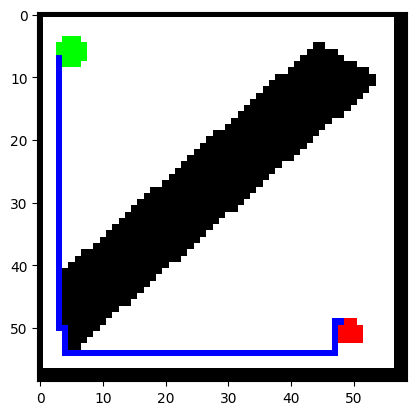

In [23]:
maze_with_path = drawPath(imagen_np, path_bfs)
plt.imshow(maze_with_path)
plt.show()

### DFS

In [29]:
path_dfs = depth_first_search(maze)
print(path_dfs)

[(49, 48), (49, 47), (49, 46), (49, 45), (49, 44), (49, 43), (49, 42), (49, 41), (49, 40), (49, 39), (49, 38), (49, 37), (49, 36), (49, 35), (49, 34), (49, 33), (49, 32), (49, 31), (49, 30), (49, 29), (49, 28), (49, 27), (49, 26), (49, 25), (49, 24), (49, 23), (49, 22), (49, 21), (49, 20), (49, 19), (49, 18), (49, 17), (49, 16), (49, 15), (49, 14), (49, 13), (49, 12), (49, 11), (50, 11), (50, 12), (50, 13), (50, 14), (50, 15), (50, 16), (50, 17), (50, 18), (50, 19), (50, 20), (50, 21), (50, 22), (50, 23), (50, 24), (50, 25), (50, 26), (50, 27), (50, 28), (50, 29), (50, 30), (50, 31), (50, 32), (50, 33), (50, 34), (50, 35), (50, 36), (50, 37), (50, 38), (50, 39), (50, 40), (50, 41), (50, 42), (50, 43), (50, 44), (50, 45), (50, 46), (50, 47), (51, 47), (51, 46), (51, 45), (51, 44), (51, 43), (51, 42), (51, 41), (51, 40), (51, 39), (51, 38), (51, 37), (51, 36), (51, 35), (51, 34), (51, 33), (51, 32), (51, 31), (51, 30), (51, 29), (51, 28), (51, 27), (51, 26), (51, 25), (51, 24), (51, 23),

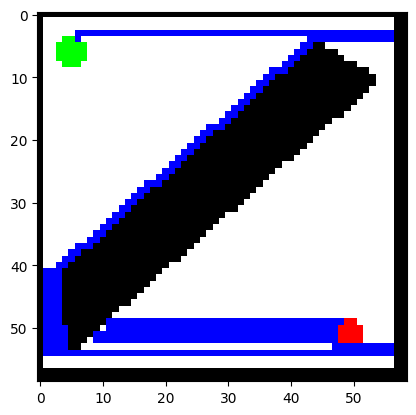

In [30]:
maze_with_path_dfs1 = drawPath(imagen_np, path_dfs)
plt.imshow(maze_with_path_dfs1)

### A*

In [31]:
path_a_star = a_star(maze, 10)
print(path_a_star)

[(49, 48), (49, 47), (49, 46), (49, 45), (49, 44), (49, 43), (49, 42), (49, 41), (49, 40), (49, 39), (49, 38), (49, 37), (49, 36), (49, 35), (49, 34), (49, 33), (49, 32), (49, 31), (49, 30), (49, 29), (49, 28), (49, 27), (49, 26), (49, 25), (49, 24), (49, 23), (49, 22), (49, 21), (49, 20), (49, 19), (49, 18), (49, 17), (49, 16), (49, 15), (49, 14), (49, 13), (49, 12), (49, 11), (50, 11), (50, 12), (50, 13), (50, 14), (50, 15), (50, 16), (50, 17), (50, 18), (50, 19), (50, 20), (50, 21), (50, 22), (50, 23), (50, 24), (50, 25), (50, 26), (50, 27), (50, 28), (50, 29), (50, 30), (50, 31), (50, 32), (50, 33), (50, 34), (50, 35), (50, 36), (50, 37), (50, 38), (50, 39), (50, 40), (50, 41), (50, 42), (50, 43), (50, 44), (50, 45), (50, 46), (50, 47), (51, 47), (51, 46), (51, 45), (51, 44), (51, 43), (51, 42), (51, 41), (51, 40), (51, 39), (51, 38), (51, 37), (51, 36), (51, 35), (51, 34), (51, 33), (51, 32), (51, 31), (51, 30), (51, 29), (51, 28), (51, 27), (51, 26), (51, 25), (51, 24), (51, 23),

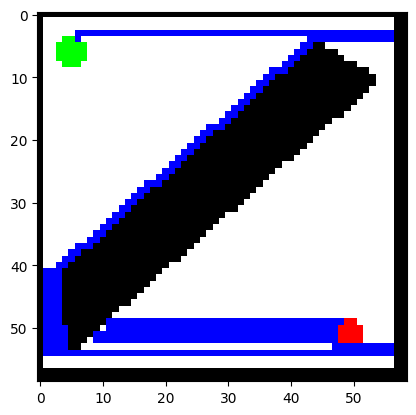

In [32]:
maze_with_path_a_star = drawPath(imagen_np, path_a_star)
plt.imshow(maze_with_path_a_star)
plt.show()

## Imagen 3

Alto: 582, Ancho: 582
Nuevo alto: 59, Nuevo ancho: 59


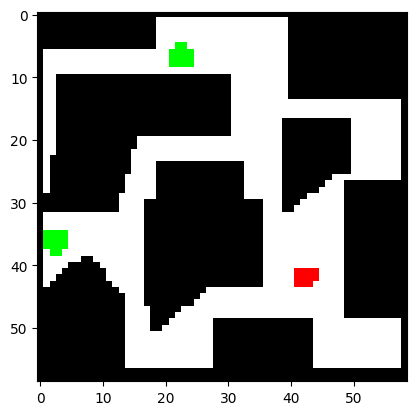

In [34]:
ruta_imagen3 = 'images/3.bmp'
tamano_bloque3 = 10
imagen_discreta3 = convertir_a_discreto(ruta_imagen3, tamano_bloque3)
plt.imshow(imagen_discreta3)
plt.show()

In [35]:
imagen_np3 = np.array(imagen_discreta3)
print(imagen_np3.shape)

(59, 59, 3)


In [37]:
maze3 = SolveMaze(imagen_np3)
print(maze3)

SolveMaze(maze=(59, 59, 3), starting_point=(41, 41))


### BFS

In [38]:
path_bfs3 = breadthFirstSearch(maze3)
print(path_bfs3)

[(41, 41), (40, 41), (39, 41), (38, 41), (37, 41), (36, 41), (35, 41), (34, 41), (33, 41), (32, 41), (32, 40), (32, 39), (32, 38), (31, 38), (30, 38), (29, 38), (28, 38), (27, 38), (26, 38), (25, 38), (24, 38), (23, 38), (22, 38), (21, 38), (20, 38), (19, 38), (18, 38), (17, 38), (16, 38), (15, 38), (14, 38), (13, 38), (12, 38), (11, 38), (10, 38), (9, 38), (8, 38), (8, 37), (8, 36), (8, 35), (8, 34), (8, 33), (8, 32), (8, 31), (8, 30), (8, 29), (8, 28), (8, 27), (8, 26), (8, 25), (8, 24)]


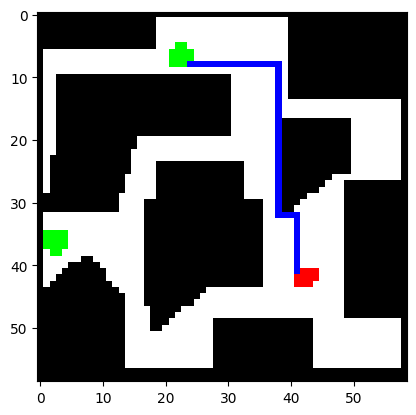

In [39]:
maze_with_path_bfs3 = drawPath(imagen_np3, path_bfs3)
maze_with_path_bfs3 = Image.fromarray(maze_with_path_bfs3)
plt.imshow(maze_with_path_bfs3)
plt.show()

### DFS

In [40]:
path_dfs3 = depth_first_search(maze3)
print(path_dfs3)


[(41, 41), (41, 40), (41, 39), (41, 38), (41, 37), (41, 36), (42, 36), (42, 37), (42, 38), (42, 39), (42, 40), (43, 40), (43, 39), (43, 38), (43, 37), (43, 36), (44, 36), (44, 37), (44, 38), (44, 39), (44, 40), (44, 41), (44, 42), (44, 43), (44, 44), (44, 45), (44, 46), (44, 47), (44, 48), (45, 48), (45, 47), (45, 46), (45, 45), (45, 44), (45, 43), (45, 42), (45, 41), (45, 40), (45, 39), (45, 38), (45, 37), (45, 36), (45, 35), (45, 34), (45, 33), (45, 32), (45, 31), (45, 30), (45, 29), (45, 28), (45, 27), (45, 26), (46, 26), (46, 27), (46, 28), (46, 29), (46, 30), (46, 31), (46, 32), (46, 33), (46, 34), (46, 35), (46, 36), (46, 37), (46, 38), (46, 39), (46, 40), (46, 41), (46, 42), (46, 43), (46, 44), (46, 45), (46, 46), (46, 47), (46, 48), (47, 48), (47, 47), (47, 46), (47, 45), (47, 44), (47, 43), (47, 42), (47, 41), (47, 40), (47, 39), (47, 38), (47, 37), (47, 36), (47, 35), (47, 34), (47, 33), (47, 32), (47, 31), (47, 30), (47, 29), (47, 28), (47, 27), (47, 26), (47, 25), (47, 24),

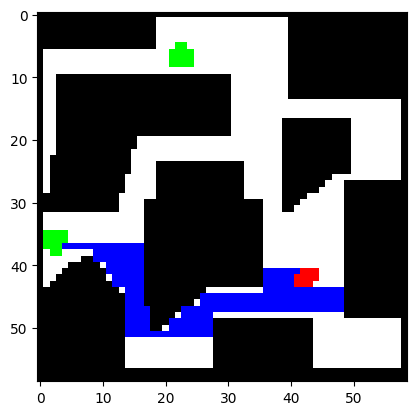

In [42]:
maze_with_path_dfs3 = drawPath(imagen_np3, path_dfs3)
maze_with_path_dfs3 = Image.fromarray(maze_with_path_dfs3)
plt.imshow(maze_with_path_dfs3)
plt.show()

### A*

In [44]:
path_a_star3 = a_star(maze3, 100)
print(path_a_star3)

[(41, 41), (41, 40), (41, 39), (41, 38), (41, 37), (41, 36), (42, 36), (42, 37), (42, 38), (42, 39), (42, 40), (43, 40), (43, 39), (43, 38), (43, 37), (43, 36), (44, 36), (44, 37), (44, 38), (44, 39), (44, 40), (44, 41), (44, 42), (44, 43), (44, 44), (44, 45), (44, 46), (44, 47), (44, 48), (45, 48), (45, 47), (45, 46), (45, 45), (45, 44), (45, 43), (45, 42), (45, 41), (45, 40), (45, 39), (45, 38), (45, 37), (45, 36), (45, 35), (45, 34), (45, 33), (45, 32), (45, 31), (45, 30), (45, 29), (45, 28), (45, 27), (45, 26), (46, 26), (46, 27), (46, 28), (46, 29), (46, 30), (46, 31), (46, 32), (46, 33), (46, 34), (46, 35), (46, 36), (46, 37), (46, 38), (46, 39), (46, 40), (46, 41), (46, 42), (46, 43), (46, 44), (46, 45), (46, 46), (46, 47), (46, 48), (47, 48), (47, 47), (47, 46), (47, 45), (47, 44), (47, 43), (47, 42), (47, 41), (47, 40), (47, 39), (47, 38), (47, 37), (47, 36), (47, 35), (47, 34), (47, 33), (47, 32), (47, 31), (47, 30), (47, 29), (47, 28), (47, 27), (47, 26), (47, 25), (47, 24),

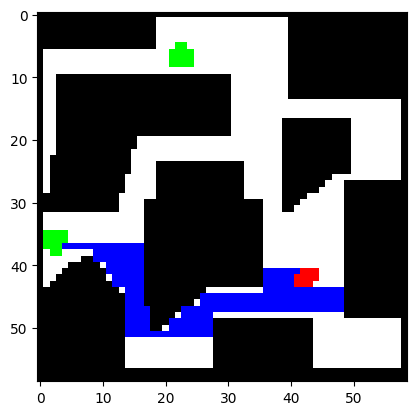

In [45]:
maze_with_path_a_star3 = drawPath(imagen_np3, path_a_star3)
maze_with_path_a_star3 = Image.fromarray(maze_with_path_a_star3)
plt.imshow(maze_with_path_a_star3)
plt.show()

## Imagen 2

Alto: 582, Ancho: 582
Nuevo alto: 59, Nuevo ancho: 59


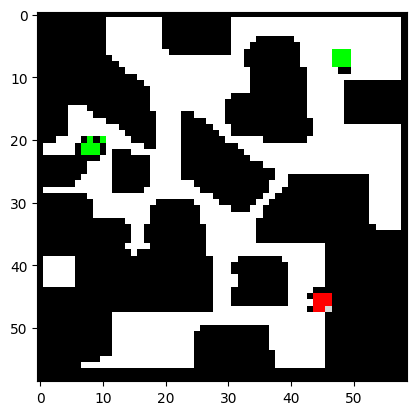

In [46]:
ruta_imagen2 = 'images/2.bmp'
tamano_bloque2 = 10
imagen_discreta2 = convertir_a_discreto(ruta_imagen3, tamano_bloque2)
plt.imshow(imagen_discreta2)
plt.show()

In [47]:
maze2 = SolveMaze(np.array(imagen_discreta2))


In [62]:
imagen_np2 = np.array(imagen_discreta2)

### BFS

In [69]:
path_dfs2 = breadthFirstSearch(maze2)
print(path_dfs2)

[(47, 45), (48, 45), (48, 44), (48, 43), (48, 42), (47, 42), (46, 42), (45, 42), (44, 42), (43, 42), (42, 42), (41, 42), (40, 42), (39, 42), (38, 42), (37, 42), (37, 41), (37, 40), (37, 39), (37, 38), (37, 37), (37, 36), (37, 35), (37, 34), (36, 34), (35, 34), (34, 34), (33, 34), (32, 34), (32, 33), (32, 32), (32, 31), (32, 30), (31, 30), (31, 29), (31, 28), (30, 28), (30, 27), (29, 27), (29, 26), (29, 25), (28, 25), (28, 24), (27, 24), (27, 23), (27, 22), (26, 22), (25, 22), (24, 22), (23, 22), (22, 22), (22, 21), (22, 20), (22, 19), (22, 18), (22, 17), (22, 16), (21, 16), (21, 15), (21, 14), (20, 14), (20, 13), (20, 12), (20, 11), (20, 10)]


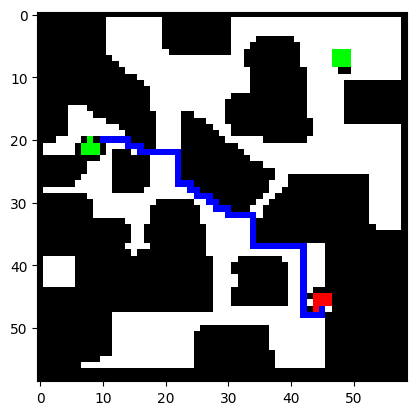

In [70]:
maze_with_path_dfs2 = drawPath(imagen_np2, path_dfs2)
maze_with_path_dfs2 = Image.fromarray(maze_with_path_dfs2)
plt.imshow(maze_with_path_dfs2)
plt.show()

### DFS

In [65]:
maze_with_path_dfs2 = depth_first_search(maze2)
print(maze_with_path_dfs2)

[(47, 45), (48, 45), (48, 44), (48, 43), (48, 42), (48, 41), (48, 40), (48, 39), (48, 38), (48, 37), (48, 36), (48, 35), (48, 34), (48, 33), (48, 32), (48, 31), (48, 30), (48, 29), (48, 28), (47, 28), (47, 29), (47, 30), (47, 31), (47, 32), (47, 33), (47, 34), (47, 35), (47, 36), (47, 37), (47, 38), (47, 39), (47, 40), (47, 41), (47, 42), (46, 42), (46, 41), (46, 40), (45, 40), (45, 41), (45, 42), (44, 42), (44, 43), (43, 43), (43, 44), (43, 45), (42, 45), (42, 44), (42, 43), (42, 42), (42, 41), (42, 40), (41, 40), (41, 41), (41, 42), (41, 43), (41, 44), (41, 45), (40, 45), (40, 44), (40, 43), (40, 42), (40, 41), (40, 40), (39, 40), (39, 41), (39, 42), (39, 43), (39, 44), (39, 45), (38, 45), (38, 44), (38, 43), (38, 42), (38, 41), (38, 40), (38, 39), (38, 38), (38, 37), (38, 36), (38, 35), (38, 34), (38, 33), (38, 32), (38, 31), (38, 30), (38, 29), (38, 28), (38, 27), (37, 27), (37, 28), (37, 29), (37, 30), (37, 31), (37, 32), (37, 33), (37, 34), (36, 34), (36, 33), (36, 32), (36, 31),

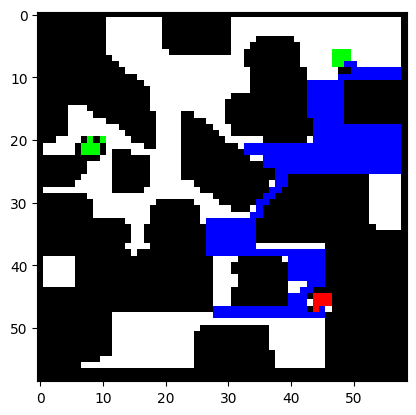

In [66]:
maze_with_path_dfs2 = drawPath(imagen_np2, maze_with_path_dfs2)
maze_with_path_dfs2 = Image.fromarray(maze_with_path_dfs2)
plt.imshow(maze_with_path_dfs2)
plt.show()

### A*

In [67]:
maze_with_path_a_star_2 = a_star(maze2, 10)
print(maze_with_path_a_star_2)

[(47, 45), (48, 45), (48, 44), (48, 43), (48, 42), (48, 41), (48, 40), (48, 39), (48, 38), (48, 37), (48, 36), (48, 35), (48, 34), (48, 33), (48, 32), (48, 31), (48, 30), (48, 29), (48, 28), (47, 28), (47, 29), (47, 30), (47, 31), (47, 32), (47, 33), (47, 34), (47, 35), (47, 36), (47, 37), (47, 38), (47, 39), (47, 40), (47, 41), (47, 42), (46, 42), (46, 41), (46, 40), (45, 40), (45, 41), (45, 42), (44, 42), (44, 43), (43, 43), (43, 44), (43, 45), (42, 45), (42, 44), (42, 43), (42, 42), (42, 41), (42, 40), (41, 40), (41, 41), (41, 42), (41, 43), (41, 44), (41, 45), (40, 45), (40, 44), (40, 43), (40, 42), (40, 41), (40, 40), (39, 40), (39, 41), (39, 42), (39, 43), (39, 44), (39, 45), (38, 45), (38, 44), (38, 43), (38, 42), (38, 41), (38, 40), (38, 39), (38, 38), (38, 37), (38, 36), (38, 35), (38, 34), (38, 33), (38, 32), (38, 31), (38, 30), (38, 29), (38, 28), (38, 27), (37, 27), (37, 28), (37, 29), (37, 30), (37, 31), (37, 32), (37, 33), (37, 34), (36, 34), (36, 33), (36, 32), (36, 31),

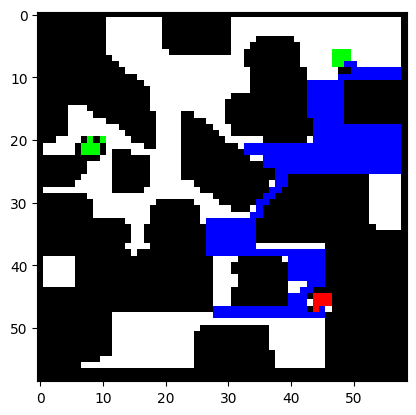

In [68]:
maze_with_path_a_star_2 = drawPath(imagen_np2, maze_with_path_a_star_2)
maze_with_path_a_star_2 = Image.fromarray(maze_with_path_a_star_2)
plt.imshow(maze_with_path_a_star_2)